# RESP pipeline example

This notebook illustrates how to use resp_protein_toolkit to train a model using data collected against
a single target or antigen of interest then run an in silico search for novel binders using the resulting
model. It takes as input two gzipped csv files included with the package under the "example_dataset" folder.
To run this script, move the example datasets from "example_dataset" to the same directory as this notebook,
check to make sure the package and optional dependencies are installed, install scikit-learn and pandas
(for use in this script specifically) and then run the remaining steps.

**IMPORTANT NOTE:** We have only conducted a very minimal set of hyperparameter tuning experiments for the model used in this notebook. It is very likely possible to achieve better performance with more extensive hyperparameter tuning for this model. Also note that for some hyperparameter settings the model can perform quite poorly. We do not suggest that you use the hyperparameters shown here for your dataset without testing them to ensure they achieve satisfactory performance. In other words: use this notebook as a guide to how to set up and run the pipeline, not as a guide to which hyperparameters to use for your deep learning model.

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef as MCC, accuracy_score, average_precision_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd

import resp_protein_toolkit 
from resp_protein_toolkit import OneHotProteinEncoder
from resp_protein_toolkit import ByteNetSingleSeq
from resp_protein_toolkit import InSilicoDirectedEvolution as ISDE

negative_examples = pd.read_csv("mHER_H3_AgNeg.csv")
positive_examples = pd.read_csv("mHER_H3_AgPos.csv")

In [2]:
negative_examples

,Unnamed: 0,Count,Fraction,NucSeq,AASeq,AgClass
0,0,7,0.000007,TGTAGCAGGTACACTATCTGCAGTTTCTACAAGCTCCAGTATTGG,YTICSFYKLQ,0
1,1,95,0.000041,TGTAGCAGGTGGTTCCTCTGCGGCTTCTACCAGAACATGTATTGG,WFLCGFYQNM,0
2,2,3,0.000001,TGTAGCAGGTTCGGCAACATCAGCTCCTTCGCGATCGCGTATTGG,FGNISSFAIA,0
3,3,10,0.000005,TGTAGCAGGTTCAAGGTCAACGGTCTGTTCCCGCACCTCTATTGG,FKVNGLFPHL,0
4,4,16,0.000016,TGTAGCAGGTACACTATCTGCAGTATGTACGAGTTCGATTATTGG,YTICSMYEFD,0
...,...,...,...,...,...,...
27534,27534,79,0.000034,TGTAGCAGGTGGGACGAGGGCGACCCCTACCCCTACCAGTATTGG,WDEGDPYPYQ,0
27535,27535,3,0.000003,TGTAGCAGGTGGCATGAGGACGGCATGTACCAGAACGAGTATTGG,WHEDGMYQNE,0
27536,27536,115,0.000049,TGTAGCAGGTACCGCGACTCCCACTCCTTCACGTTCGTCTATTGG,YRDSHSFTFV,0
27537,27537,14,0.000006,TGTAGCAGGTGGGACGTCCTCAACTACTTCGTGTTCATCTATTGG,WDVLNYFVFI,0


The input data contains two columns, one of which is a sequence and the other of which is the assigned category.
This is a binary classification task. These are very short sequences (10 AAs only) so we'll use a very simple
neural network for this task.

In [3]:
all_sequences = negative_examples.AASeq.tolist() + positive_examples.AASeq.tolist()
all_labels = negative_examples.AgClass.tolist() + positive_examples.AgClass.tolist()

We'll write a short training function and evaluation function for checking performance on the validation set. We'll also split the data into train and validation. This dataset is sufficiently small that if we are using one-hot encoding we can save the encodings in memory. For larger datasets, it may be necessary to encode each minibatch immediately before feeding it to the model -- this is fast if using one-hot encoding. If the sequence representations are very expensive to generate, it may be better to encode the data
and save it to disk (although this can require a large amount of disk space for high-dimensional embeddings). Either way, a PyTorch
dataloader can be helpful here.

Finally, we'll construct a cnn model using the ByteNet variant that is part of this package with a last-layer
Gaussian process so that we can estimate uncertainty on our predictions. There are of course a number of hyperparameters --
minibatch size, learning rate, the number of layers, dropout, the dilution factor, the hidden dim size and so on -- that can be altered to try to improve the performance of this model, and in real applications it may be useful to do some preliminary experiments and estimate
performance on a validation set. For the sake of simplicity, in this example we've done only a couple rounds of hyperparameter tuning
and found some settings that worked well enough for this demo -- in a real world application, you may want to experiment with other architectures or tune more extensively.

In [4]:
# Use alphabet = "gapped" here if sequences contain gaps. In this case they do not. Notice that if you
# want InSilicoDirectedEvolution to introduce gaps into your starting sequence when optimizing it,
# use the "gapped" alphabet here.
one_hot_encoder = OneHotProteinEncoder(alphabet="standard")
xvalues = one_hot_encoder.encode(all_sequences)
yvalues = np.array(all_labels)

In [5]:
def model_train(model, xdata, ydata, epochs=2,
                    minibatch=500, random_seed=123,
                    optimizer=None, scheduler=None):
    """Simple model train function, easily adapted for more complex
    problems."""
    model = model.train()
    model = model.cuda()

    # The loss function here is BCELoss. You may need to change this if you
    # are for example doing regression or want to use a different loss function.
    loss_fn = torch.nn.BCELoss()

    for epoch in range(0, epochs):

        for j in range(0, xdata.shape[0], minibatch):
            xmini, ymini = xdata[j:j+minibatch,...], ydata[j:j+minibatch]
            # Important to convert to float because the onehot data is
            # a uint8 array (to save on memory).
            xmini = torch.from_numpy(xmini).float().cuda()
            ymini = torch.from_numpy(ymini).float().cuda()

            # EXTREMELY important to use update_precision on the training loop --
            # otherwise the covariance estimate will not be updated during
            # training!
            y_pred = model(xmini, update_precision=True)
            loss = loss_fn(y_pred, ymini)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()
            print(scheduler.get_last_lr())
        print("Epoch complete")

    # The ByteNet model will automatically reset to eval when we call its
    # "predict" method, but this may be necessary for other models.
    model = model.eval()

In [6]:
xtrain, xval, ytrain, yval = train_test_split(xvalues, yvalues,
                            test_size=0.2, random_state=123, shuffle=True)

In [7]:
def eval_model(model, xdata, ydata, get_full_predictions=True, batch_size=500):
    # Important to feed the data to the model in batches, since trying to generate
    # predictions on a large dataset all at once will lead to out of memory.
    predicted_y, variance = [], []

    for j in range(0, xdata.shape[0], batch_size):
        xbatch = xdata[j:j+batch_size,...]
        # The predict method of the model will convert the numpy input to
        # a pytorch float array, send it to the appropriate device, then
        # return us numpy arrays on CPU.
        if get_full_predictions:
            preds, var = model.predict(xbatch, get_var = True)
            predicted_y.append(preds)
            variance.append(var)
        else:
            predicted_y.append(model.predict(xbatch))

    predicted_y = np.concatenate(predicted_y)
    predicted_categories = np.rint(predicted_y)
    mcc = MCC(ydata, predicted_categories)
    avprc = average_precision_score(ydata, predicted_y)
    accuracy = accuracy_score(ydata, predicted_categories)

    if get_full_predictions:
        return mcc, avprc, accuracy, predicted_y, np.concatenate(variance)
    return mcc, avprc, accuracy

In [8]:
train_mcc, train_auc_prc, train_accuracy = [], [], []
val_mcc, val_auc_prc, val_accuracy = [], [], []

nepochs = 50

# See the "Built-in models for protein sequence data" section of the docs
# for more on what these arguments do. input_dim is 20 because we used the
# standard alphabet with one-hot encoding (if there were gaps, we would
# specify 21 instead). Many other arguments are hyperparameters we can
# tune. The "llgp" argument is True if we want an uncertainty-aware model,
# False otherwise. "objective" is "binary_classifier" because we have a classification
# task; otherwise, it might be "regression" or "multiclass". If "multiclass",
# we would have to supply another argument, "num_predicted_categories"
# as well.

base_model = ByteNetSingleSeq(input_dim=20, hidden_dim=21, n_layers=2,
                              kernel_size=5, dil_factor=1, rep_dim=100,
                              pool_type = "max",
                              dropout=0.2, slim=False, llgp=True,
                              objective="binary_classifier")

# The weight decay and learning rate may also need to be optimized. In a real
# project, you may want to set up a config file with parameters like these
# and experiment with them on a validation set.

optimizer = torch.optim.Adam(base_model.parameters(), lr = 0.0005,
                                 weight_decay = 1e-6)

for i in range(int(nepochs / 2)):
    _ = model_train(base_model, xtrain, ytrain, epochs=2,
                     minibatch=200, random_seed=123,
                    optimizer = optimizer)
    print(f"{i * 2 + 2} epochs", flush=True)

    mcc, aucprc, accuracy = eval_model(base_model, xtrain, ytrain, False)
    train_mcc.append(mcc)
    train_auc_prc.append(aucprc)
    train_accuracy.append(accuracy)

    mcc, aucprc, accuracy = eval_model(base_model, xval, yval, False)
    val_mcc.append(mcc)
    val_auc_prc.append(aucprc)
    val_accuracy.append(accuracy)

Epoch complete
Epoch complete
2 epochs
Epoch complete
Epoch complete
4 epochs
Epoch complete
Epoch complete
6 epochs
Epoch complete
Epoch complete
8 epochs
Epoch complete
Epoch complete
10 epochs
Epoch complete
Epoch complete
12 epochs
Epoch complete
Epoch complete
14 epochs
Epoch complete
Epoch complete
16 epochs
Epoch complete
Epoch complete
18 epochs
Epoch complete
Epoch complete
20 epochs
Epoch complete
Epoch complete
22 epochs
Epoch complete
Epoch complete
24 epochs
Epoch complete
Epoch complete
26 epochs
Epoch complete
Epoch complete
28 epochs
Epoch complete
Epoch complete
30 epochs
Epoch complete
Epoch complete
32 epochs
Epoch complete
Epoch complete
34 epochs
Epoch complete
Epoch complete
36 epochs
Epoch complete
Epoch complete
38 epochs
Epoch complete
Epoch complete
40 epochs
Epoch complete
Epoch complete
42 epochs
Epoch complete
Epoch complete
44 epochs
Epoch complete
Epoch complete
46 epochs
Epoch complete
Epoch complete
48 epochs
Epoch complete
Epoch complete
50 epochs


It's very important to check that the validation set performance is acceptable before you proceed. If not,
consider changing hyperparameters, or using a different model architecture. In this case, since this notebook
is purely for demonstration purposes, we proceed with the model as-is rather than trying to refine it further.

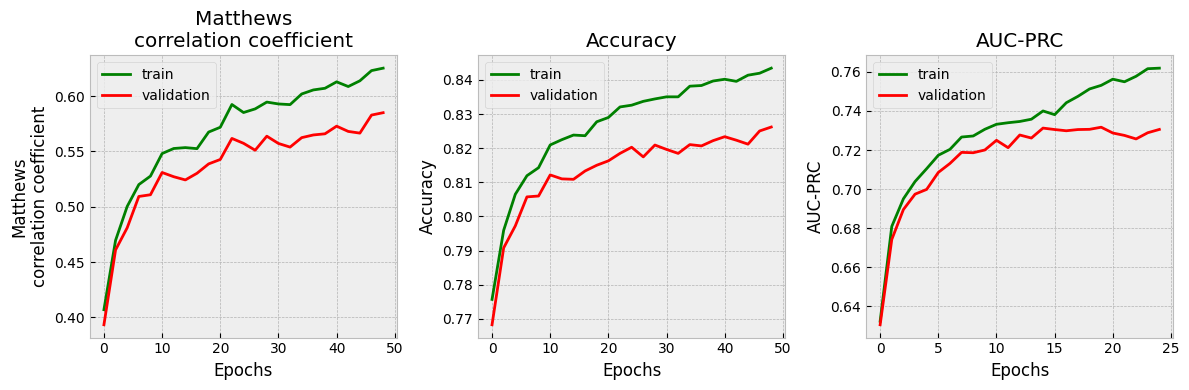

In [9]:
plt.style.use("bmh")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

ax1.plot(np.arange(0, nepochs, 2), train_mcc, color="green", label="train")
ax1.plot(np.arange(0, nepochs, 2), val_mcc, color="red", label="validation")

ax2.plot(np.arange(0, nepochs, 2), train_accuracy, color="green", label="train")
ax2.plot(np.arange(0, nepochs, 2), val_accuracy, color="red", label="validation")

ax3.plot(train_auc_prc, color="green", label="train")
ax3.plot(val_auc_prc, color="red", label="validation")

ax1.set_title("Matthews\ncorrelation coefficient")
ax2.set_title("Accuracy")
ax3.set_title("AUC-PRC")

ax1.set_ylabel("Matthews\ncorrelation coefficient")
ax2.set_ylabel("Accuracy")
ax3.set_ylabel("AUC-PRC")

ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_xlabel("Epochs")
ax2.set_xlabel("Epochs")
ax3.set_xlabel("Epochs")

plt.tight_layout()

It's also important to see what the uncertainty calibration looks like. Here's an easy way to
do this with scikit-learn.

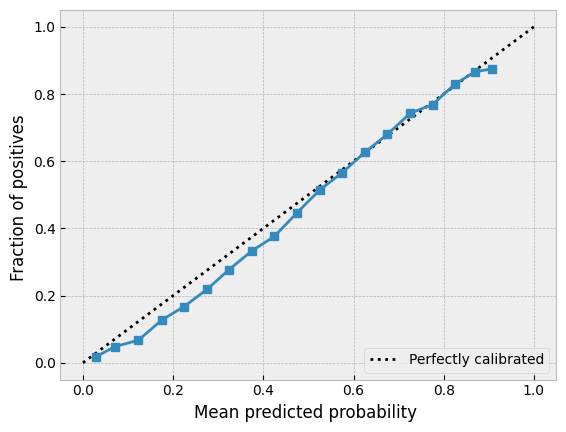

In [10]:
_, _, _, pred_y, variance = eval_model(base_model, xtrain, ytrain, True)

prob_true, prob_pred = calibration_curve(ytrain, pred_y, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, pred_y)
disp.plot()

If we are happy with the results we will proceed. We could probably achieve further improvement by tweaking
the hyperparameters further, but for this demonstration notebook we'll simply proceed.

Next let's look at the variance and use the 95th percentile on the training set as a threshold for the maximum uncertainty we're willing to allow. The LLGP configuration should also ensure that p(y=1) should go to 0.5 as we go further from the training set which will provide us with another safeguard as well. (It's a good idea to test this assumption, but for this demo notebook we'll skip this step.)

Notice that for some applications, especially regression, we can set a variance threshold by taking into account what kind of value
we are trying to predict and setting a threshold for how wide of a window we can tolerate.

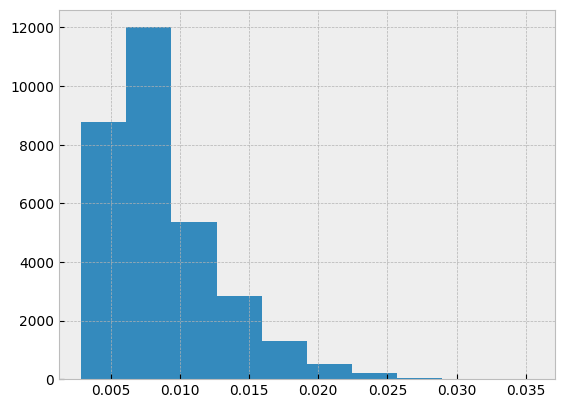

In [11]:
_ = plt.hist(variance)

In [12]:
print(np.percentile(variance, 95))

0.017021317


Now we'll set up an object that houses our model. When provided with a sequence, this object will 1) encode the sequence, 2) make
a prediction and 3) return the predicted score ( p(y=1) ) and the variance. Once we have this object we can feed it to the InSilicoDirectedEvolution class, which will run an in silico search for improved sequences.

Notice that it's important for the object to return two 1d numpy arrays each of which has the same shape[0]
as there are number of antigens. In this case there is one antigen so it should return two numpy arrays of shape[0] = 1. When
setting up the ISDE, we can also enter a probability distribution that indicates the probability of each AA at each
position -- this should be an array of shape (sequence_length, 21). In this case, we do not want to introduce any gaps
but all other AAs are ok, so we'll set a probability distribution where all elements are 1/20 except the last column
which will be zero. Because we set our sequence encoder to use a non-gapped alphabet, trying to encode a proposed sequence
that contained gaps in this case would actually cause an error.

In [13]:
class SequenceAssessor:

    def __init__(self, model, encoder):
        self.encoder = encoder
        self.model = model

    def predict(self, sequence):
        encoded_seq = self.encoder.encode([sequence])
        pred, var = self.model.predict(encoded_seq, get_var=True)
        return pred, var

In [14]:
prob_distro = np.ones((10,21))
prob_distro[:,-1] = 0
prob_distro /= prob_distro.sum(axis=1)[:,None]

In [16]:
isde = ISDE(SequenceAssessor(base_model, one_hot_encoder),
            uncertainty_threshold = np.percentile(variance, 95), prob_distro = prob_distro, seed=123)

Usually we start with the wild type as our starting sequence; for this demo, we'll just use a known nonbinder as a starting point
then optimize this sequence.

In [17]:
starting_sequence = "YTICSFYKLQ"

isde.run_chain(starting_sequence, max_iterations = 3000, cooldown = 0.99)

Temperature: 2.026462904054532
Temperature: 0.16426207606036508
Temperature: 0.013314840147172557


Now that the in silico directed evolution experiment has run, we can retrieve the results. Usually you'll need
to run multiple experiments with different starting random seeds and/or starting sequences to thoroughly explore
the region of sequence space that you're interested in. For this demo, we'll content ourselves with a single ISDE
chain. First, let's see how the sequence scores changed over time.

Text(0.5, 0, 'Iteration number')

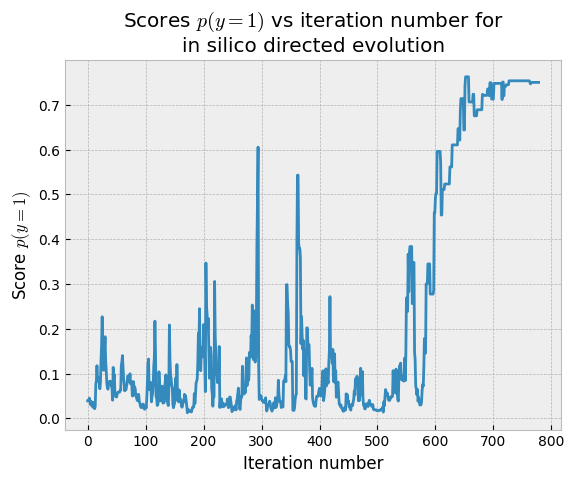

In [19]:
plt.plot(isde.get_scores())
plt.title("Scores $p(y=1)$ vs iteration number for\nin silico directed evolution")
plt.ylabel("Score $p(y=1)$")
plt.xlabel("Iteration number")

In this case, the chain spent a long time exploring before it converged on some sequences that had high probability of being binders. If we're unahppy with this result, we could re-run the chain changing the cooldown rate (lower numbers cause the chain to converge faster but may mean more limited exploration) or other settings.

For now, let's look at the accepted sequences. Notice that we have to filter the accepted sequences, because many of them are from the early stages of exploration and have low scores. We want sequences that have high probability of being binders, so we'll filter the accepted sequences for anything associated with a score above 0.7. 0.7 is arbitrary and can be set variously depending on how many sequences you can afford to test experimentally and on how confident you want to be about the sequences that are selected.

In [22]:
accepted_seqs, accepted_scores = isde.get_accepted_seqs(), isde.get_scores().flatten().tolist()

filtered_seqs = [f for (f,s) in zip(accepted_seqs, accepted_scores) if s > 0.7]
print(len(filtered_seqs))

119


Our exploration has yielded 119 sequences that we can consider for further optimization, depending on our criteria.